# Arrival Forecasting of Onion

In [1]:
# importing some important libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pylab
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

### Reading Data

In [2]:
data= pd.read_excel('onion_data.xlsx')

In [3]:
data.head()

,Date,Arrival
0,2008-01-01,670.0
1,2008-01-02,1675.0
2,2008-01-03,600.0
3,2008-01-04,545.0
4,2008-01-05,1440.0


In [4]:
data=data.set_index('Date')
data.index

DatetimeIndex(['2008-01-01', '2008-01-02', '2008-01-03', '2008-01-04',
               '2008-01-05', '2008-01-06', '2008-01-07', '2008-01-08',
               '2008-01-09', '2008-01-10',
               ...
               '2010-08-22', '2010-08-23', '2010-08-24', '2010-08-25',
               '2010-08-26', '2010-08-27', '2010-08-28', '2010-08-29',
               '2010-08-30', '2010-08-31'],
              dtype='datetime64[ns]', name='Date', length=974, freq=None)

### Converting to monthly data to have a broad outlook of the dataset


In [5]:
data1=data['Arrival'].resample('MS').mean().to_frame()

In [6]:
# monthly data
data1.head()

,Arrival
Date,
2008-01-01,1024.677419
2008-02-01,945.689655
2008-03-01,1004.112903
2008-04-01,891.166667
2008-05-01,1106.129032


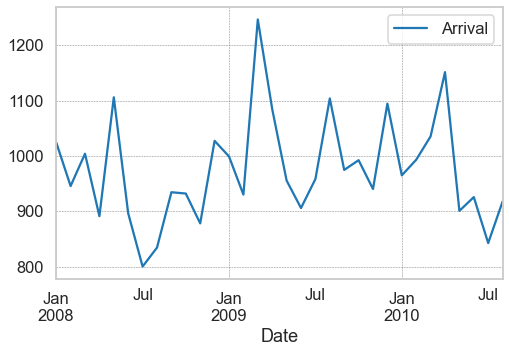

In [7]:
data1.plot(figsize=(8,5)).grid(color='gray', linestyle='--', linewidth=0.5)

In [8]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32 entries, 2008-01-01 to 2010-08-01
Freq: MS
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Arrival  32 non-null     float64
dtypes: float64(1)
memory usage: 512.0 bytes


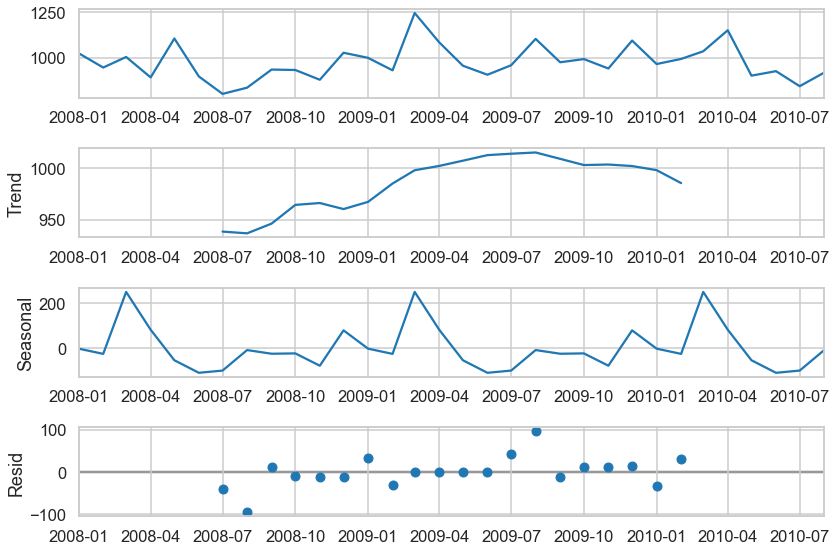

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
ts_decomp=sm.tsa.seasonal_decompose(data1,model='additive')
ts_decomp.plot()
plt.show()

### Splitting the data into train and test

In [10]:
train = data1[:len(data1)-6] # 26 months
test = data1[len(data1)-6:] # 6 months

In [11]:
train[-2:]

,Arrival
Date,
2010-01-01,965.000000
2010-02-01,993.214286


In [12]:
test

,Arrival
Date,
2010-03-01,1035.483871
2010-04-01,1151.666667
2010-05-01,900.806452
2010-06-01,925.666667
2010-07-01,842.583871
2010-08-01,917.741935


Text(0.5, 1.0, 'Train data')

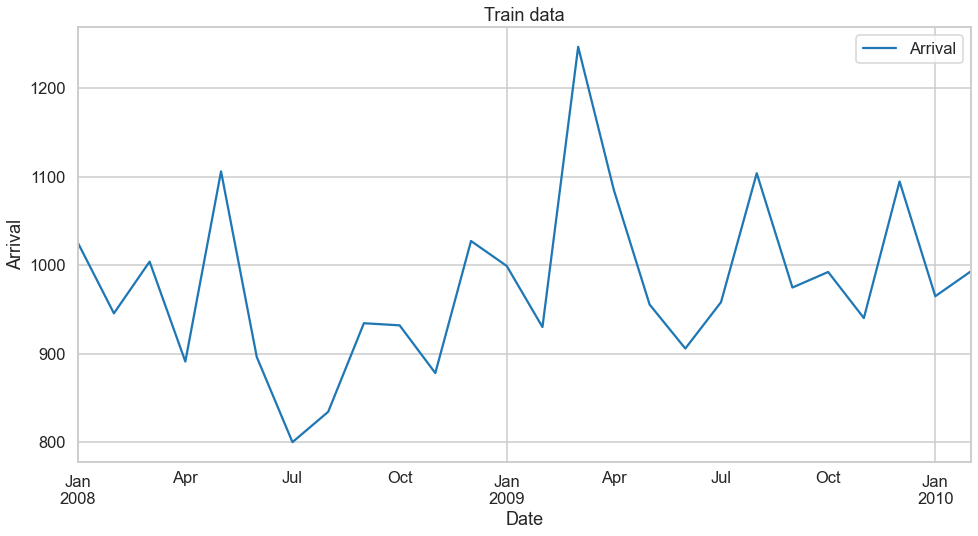

In [13]:
train.plot(figsize=(16,8))
plt.xlabel('Date')
plt.ylabel('Arrival')
plt.title('Train data')

<AxesSubplot:xlabel='Date'>

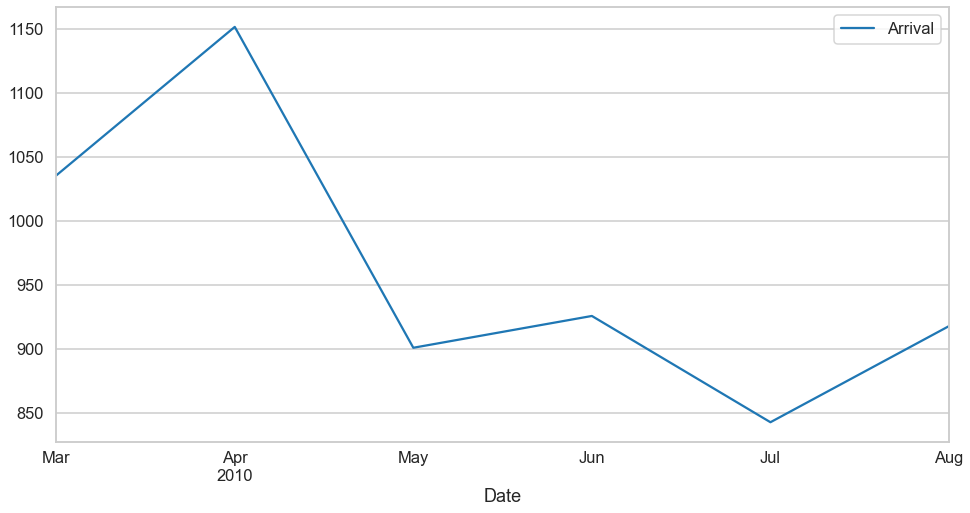

In [14]:
test.plot(figsize=(16,8))

In [15]:
result = adfuller(train['Arrival'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.242884
p-value: 0.000557


- Since the p-value here is less than 0.05, the training data is already stationary.

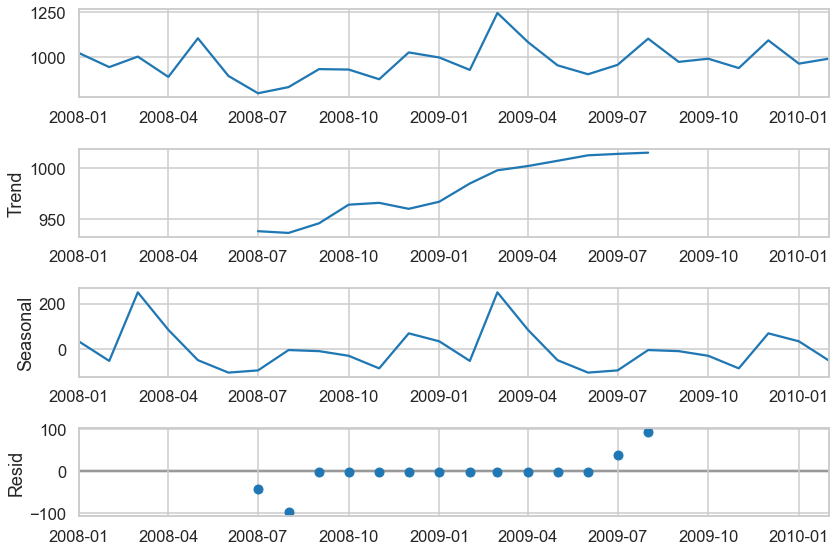

In [16]:
pylab.rcParams['figure.figsize'] = (12, 8)
ts_decomp=sm.tsa.seasonal_decompose(train,model='additive')
ts_decomp.plot()
plt.show()

In [17]:
# since our data is seasonal - considering monthly seasonal!
train['seasonal_order_diff'] = train['Arrival']-train['Arrival'].shift(12)
train.head()

,Arrival,seasonal_order_diff
Date,,
2008-01-01,1024.677419,NaN
2008-02-01,945.689655,NaN
2008-03-01,1004.112903,NaN
2008-04-01,891.166667,NaN
2008-05-01,1106.129032,NaN


### ACF and PACF of monthly data


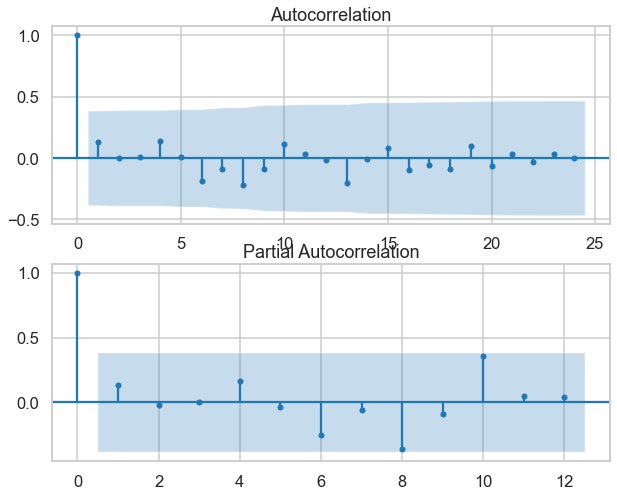

In [18]:
fig,ax = plt.subplots(2, figsize=(10,8))
ax[0] = sm.graphics.tsa.plot_acf(train['Arrival'],ax=ax[0],lags=24)
ax[1] = sm.graphics.tsa.plot_pacf(train['Arrival'],ax=ax[1],lags=12)

### Considering some parameters based on the above ACF and PACF plots!


Models considered:
- ARIMA(0,0,0) X (0,1,0)12
- ARIMA(0,0,0) X (1,1,0)12
- ARIMA(0,0,0) X (0,1,1)12
- ARIMA(0,0,1) X (1,1,1)12

In [19]:
model1 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(0, 0, 0),seasonal_order=(0, 1, 0, 12))
model_aic1 = model1.fit()  
print(model_aic1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.69e+04   6651.182      2.541      0.011    3866.669    2.99e+04


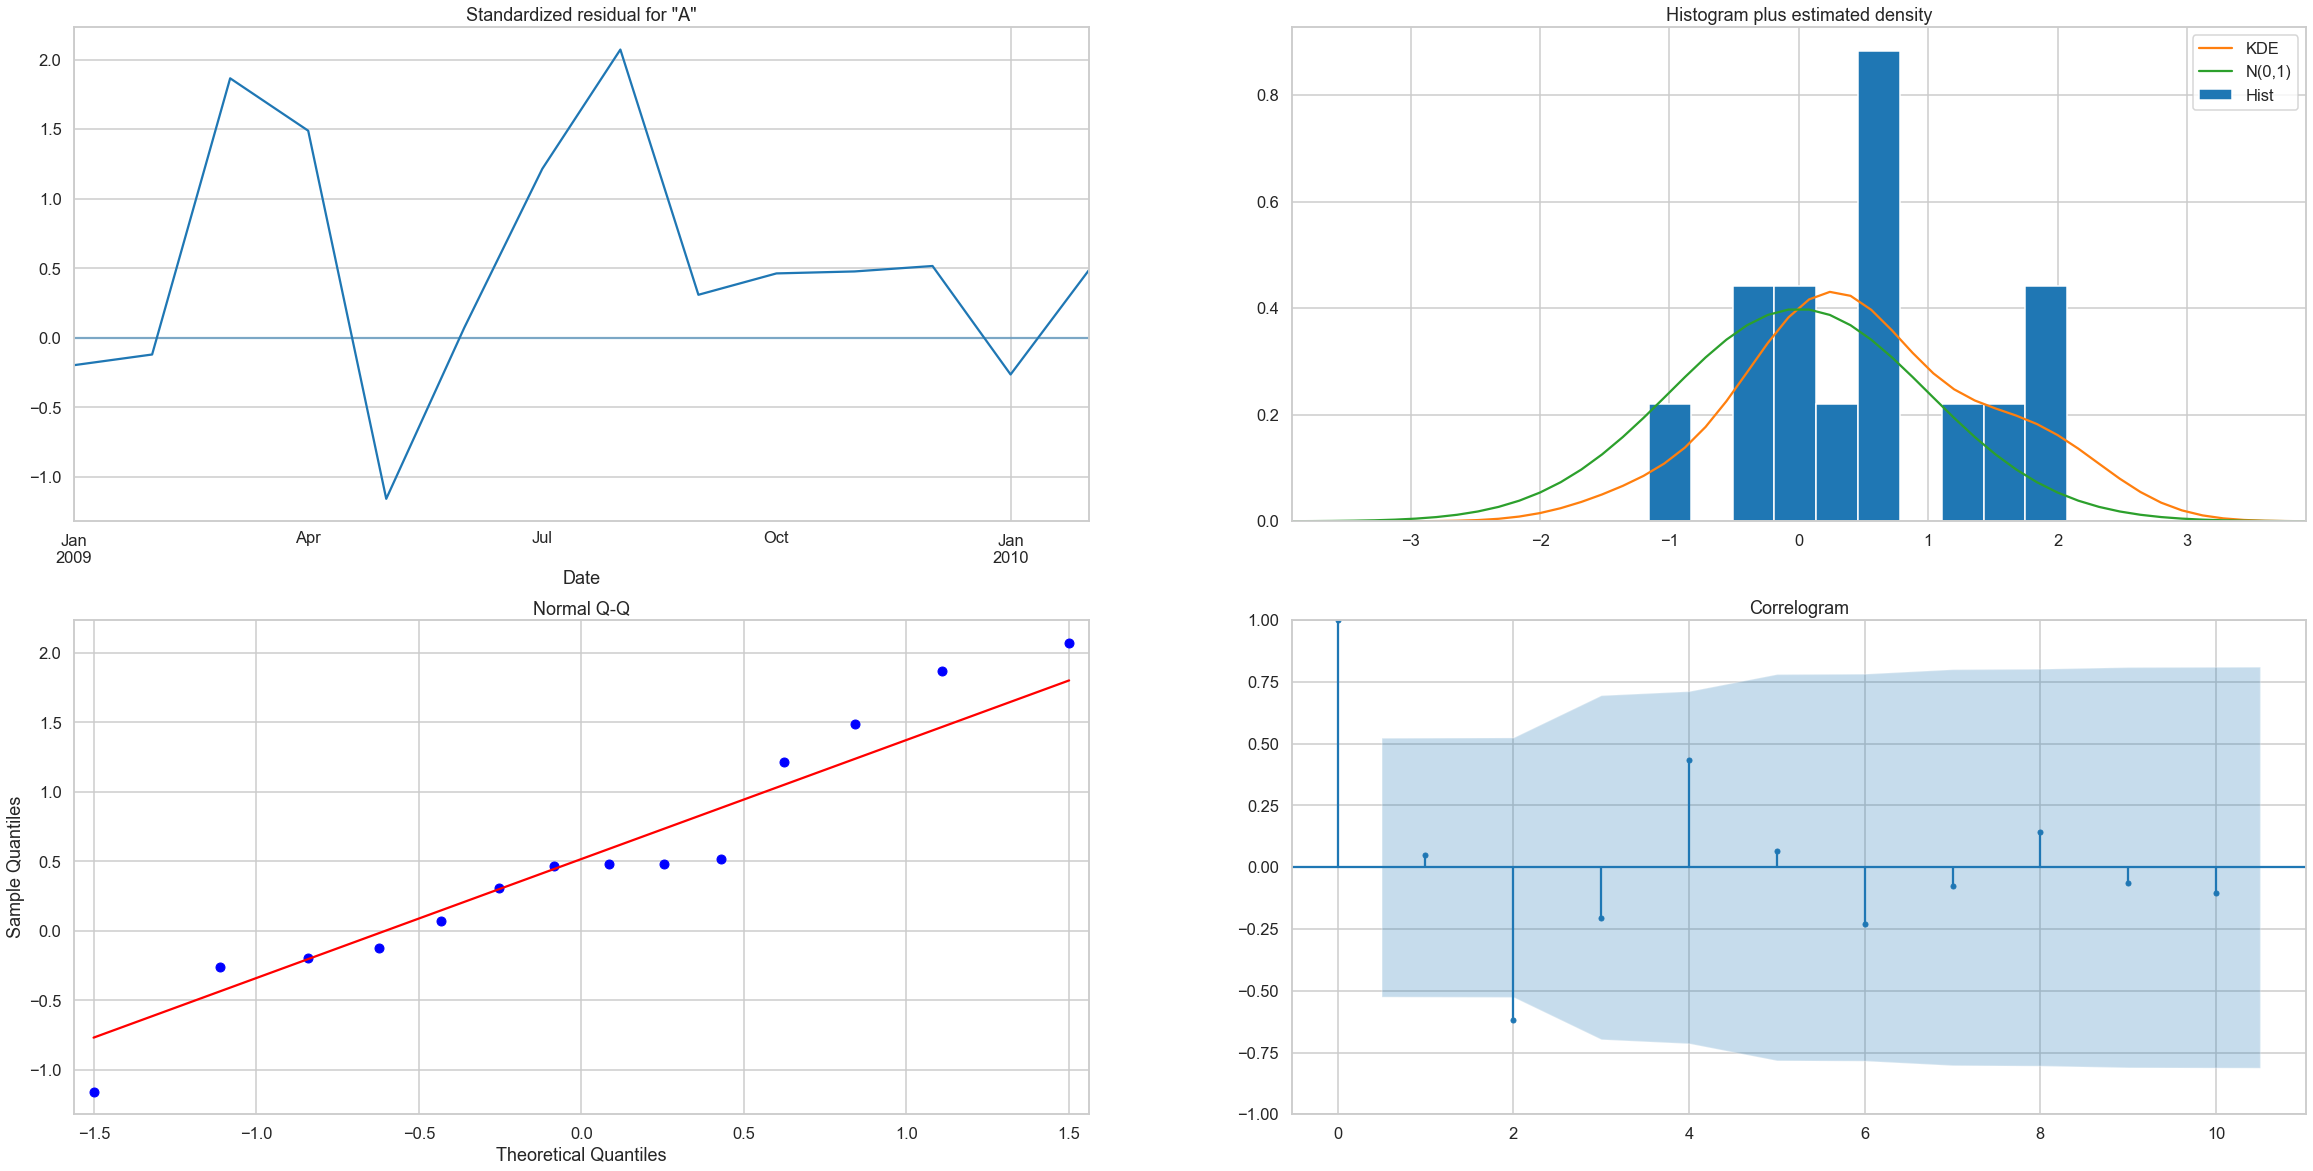

In [20]:
model_aic1.plot_diagnostics(figsize=(40,20))
plt.show()

In [21]:
#data1 = data1.to_frame()
data1['model1'] = model_aic1.predict(start=25, end=31, dynamic=True)
data1.tail(7)

,Arrival,model1
Date,,
2010-02-01,993.214286,930.178571
2010-03-01,1035.483871,1246.903226
2010-04-01,1151.666667,1084.933333
2010-05-01,900.806452,955.645161
2010-06-01,925.666667,905.900000
2010-07-01,842.583871,958.290323
2010-08-01,917.741935,1104.032258


<AxesSubplot:xlabel='Date'>

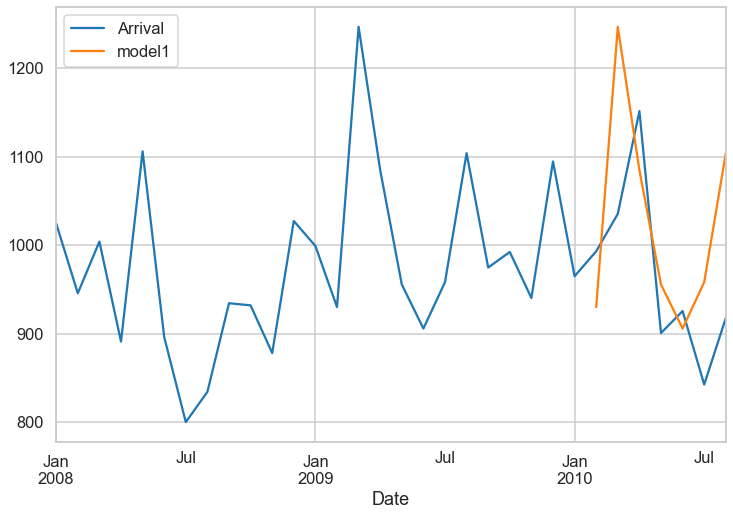

In [22]:
data1[['Arrival','model1']].plot(figsize=(12,8))

In [23]:
model2 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(0, 0, 0),seasonal_order=(1, 1, 0, 12))
model_aic2 = model2.fit()
print(model_aic1.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.69e+04   6651.182      2.541      0.011    3866.669    2.99e+04


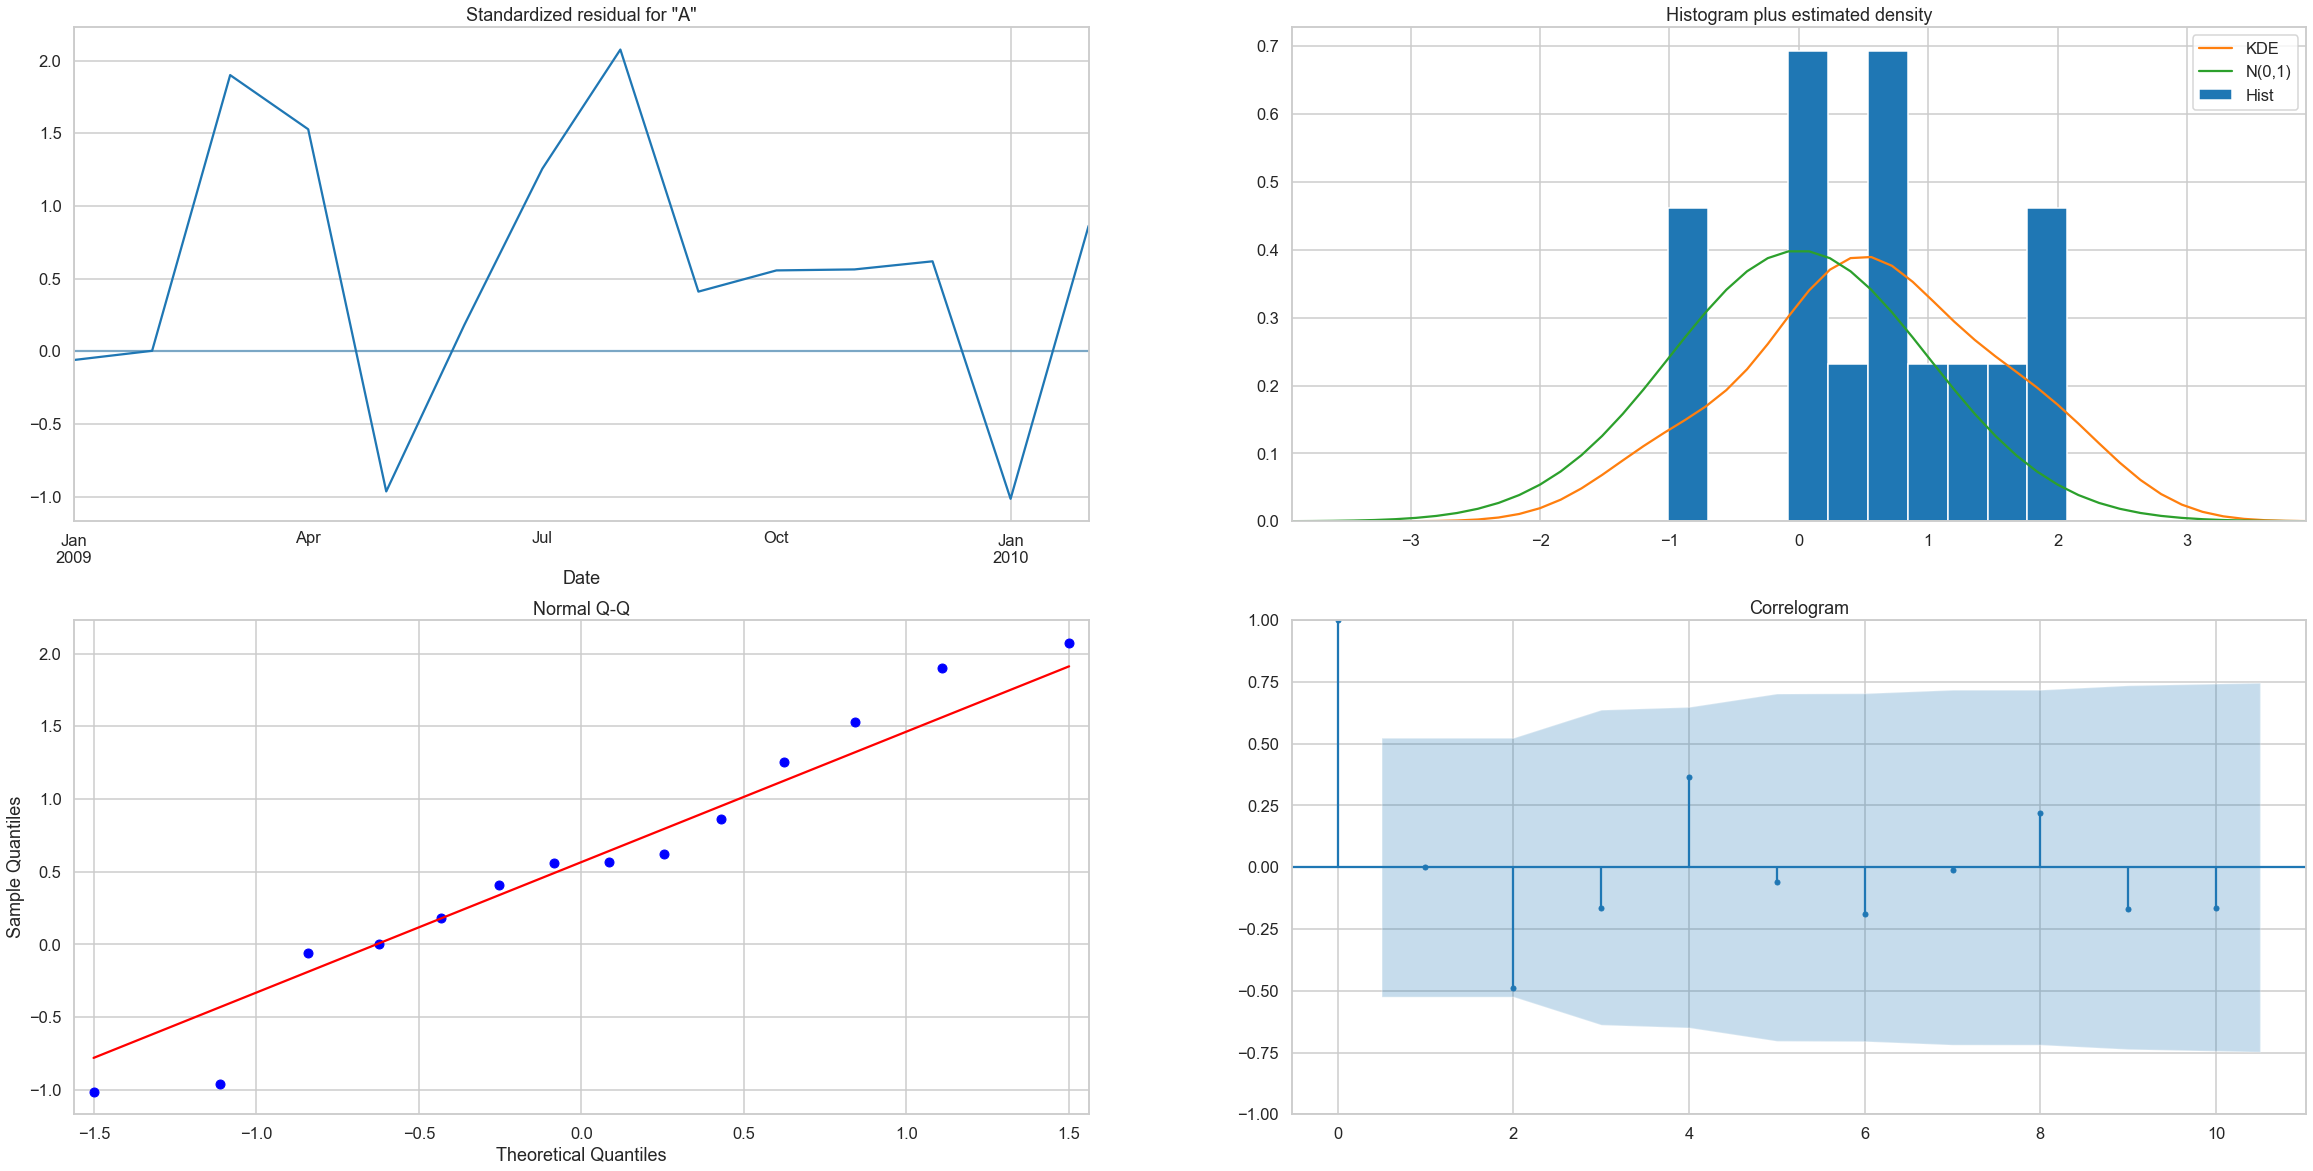

In [24]:
model_aic2.plot_diagnostics(figsize=(40,20))
plt.show()

In [25]:
#data1 = data1.to_frame()
data1['model2'] = model_aic2.predict(start=25, end=31, dynamic=True)
data1.tail(7)

,Arrival,model1,model2
Date,,,
2010-02-01,993.214286,930.178571,944.319381
2010-03-01,1035.483871,1246.903226,1025.561384
2010-04-01,1151.666667,1084.933333,908.284321
2010-05-01,900.806452,955.645161,1092.835049
2010-06-01,925.666667,905.900000,897.178468
2010-07-01,842.583871,958.290323,814.086547
2010-08-01,917.741935,1104.032258,858.178569


<AxesSubplot:xlabel='Date'>

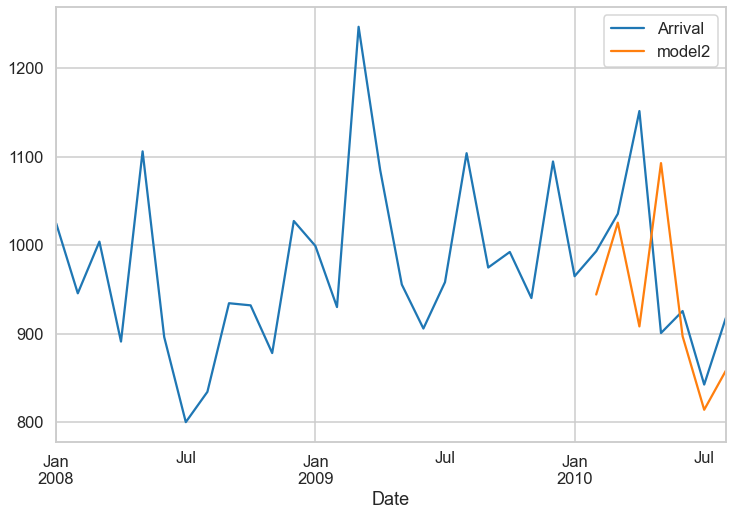

In [26]:
data1[['Arrival','model2']].plot(figsize=(12,8))

In [27]:
model3 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(0, 0, 0),seasonal_order=(0, 1, 1, 12))
model_aic3 = model3.fit()  
print(model_aic3.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.9776    102.590      0.010      0.992    -200.096     202.051
sigma2      8711.4202   8.94e+05      0.010      0.992   -1.74e+06    1.76e+06


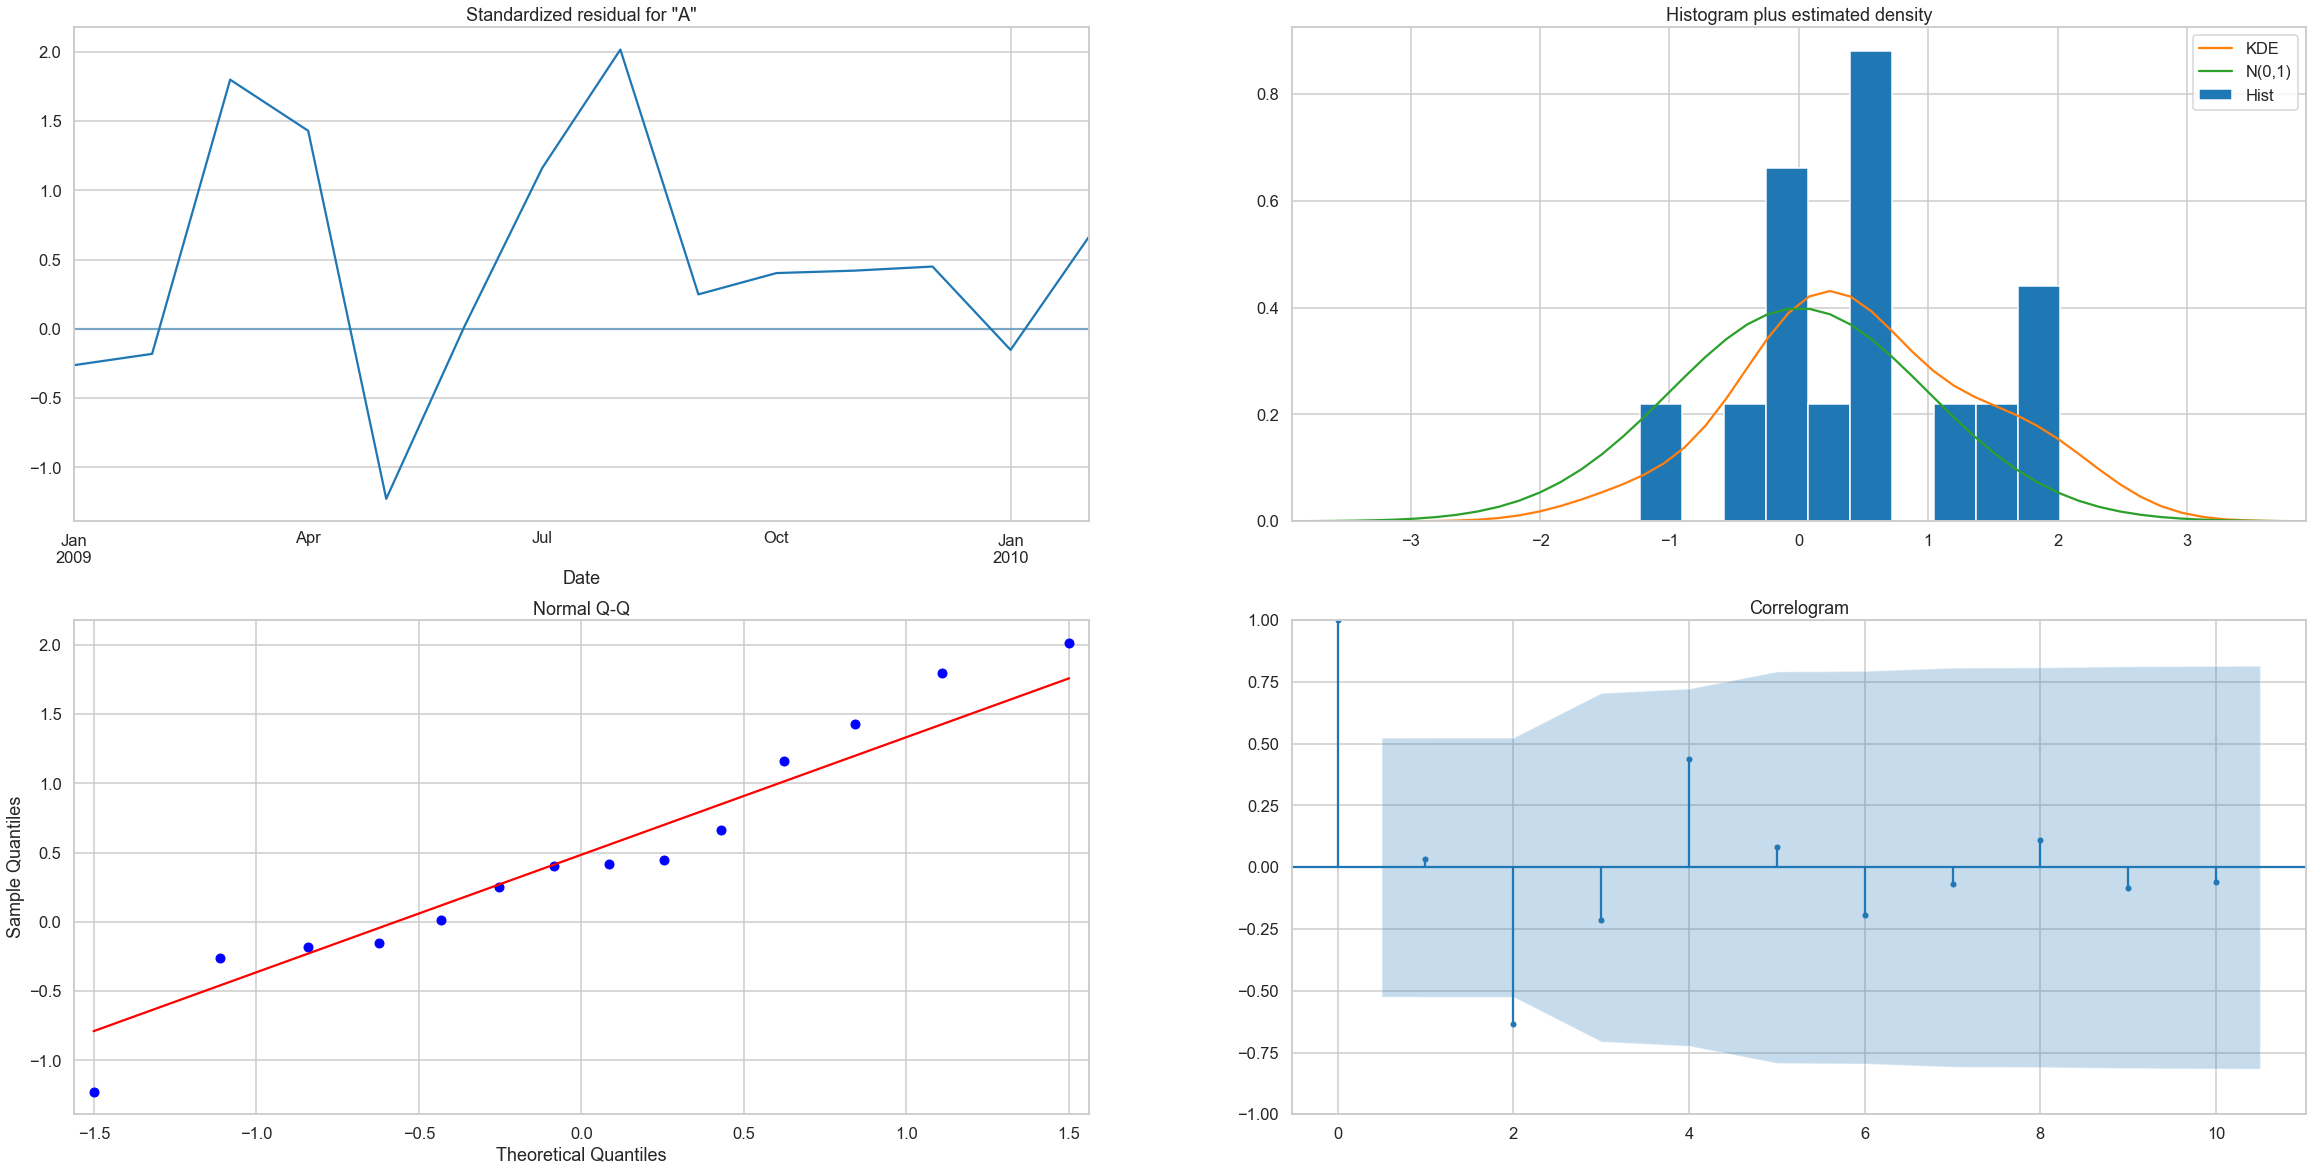

In [28]:
model_aic3.plot_diagnostics(figsize=(40,20))
plt.show()

In [29]:
#data1 = data1.to_frame()
data1['model3'] = model_aic3.predict(start=25, end=31, dynamic=True)
data1.tail(7)

,Arrival,model1,model2,model3
Date,,,,
2010-02-01,993.214286,930.178571,944.319381,918.417457
2010-03-01,1035.483871,1246.903226,1025.561384,1364.556773
2010-04-01,1151.666667,1084.933333,908.284321,1178.453090
2010-05-01,900.806452,955.645161,1092.835049,875.457038
2010-06-01,925.666667,905.900000,897.178468,906.934687
2010-07-01,842.583871,958.290323,814.086547,1034.327975
2010-08-01,917.741935,1104.032258,858.178569,1235.895928


In [30]:
model4 = sm.tsa.statespace.SARIMAX(train['Arrival'],order=(0, 0, 1),seasonal_order=(1, 1, 1, 12))
model_aic4=model4.fit()
print(model_aic4.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4559      0.453      1.005      0.315      -0.433       1.344
ar.S.L12       0.9949      0.057     17.344      0.000       0.882       1.107
ma.S.L12      -0.7358      1.510     -0.487      0.626      -3.696       2.224
sigma2      2077.4287      0.001   2.68e+06      0.000    2077.427    2077.430


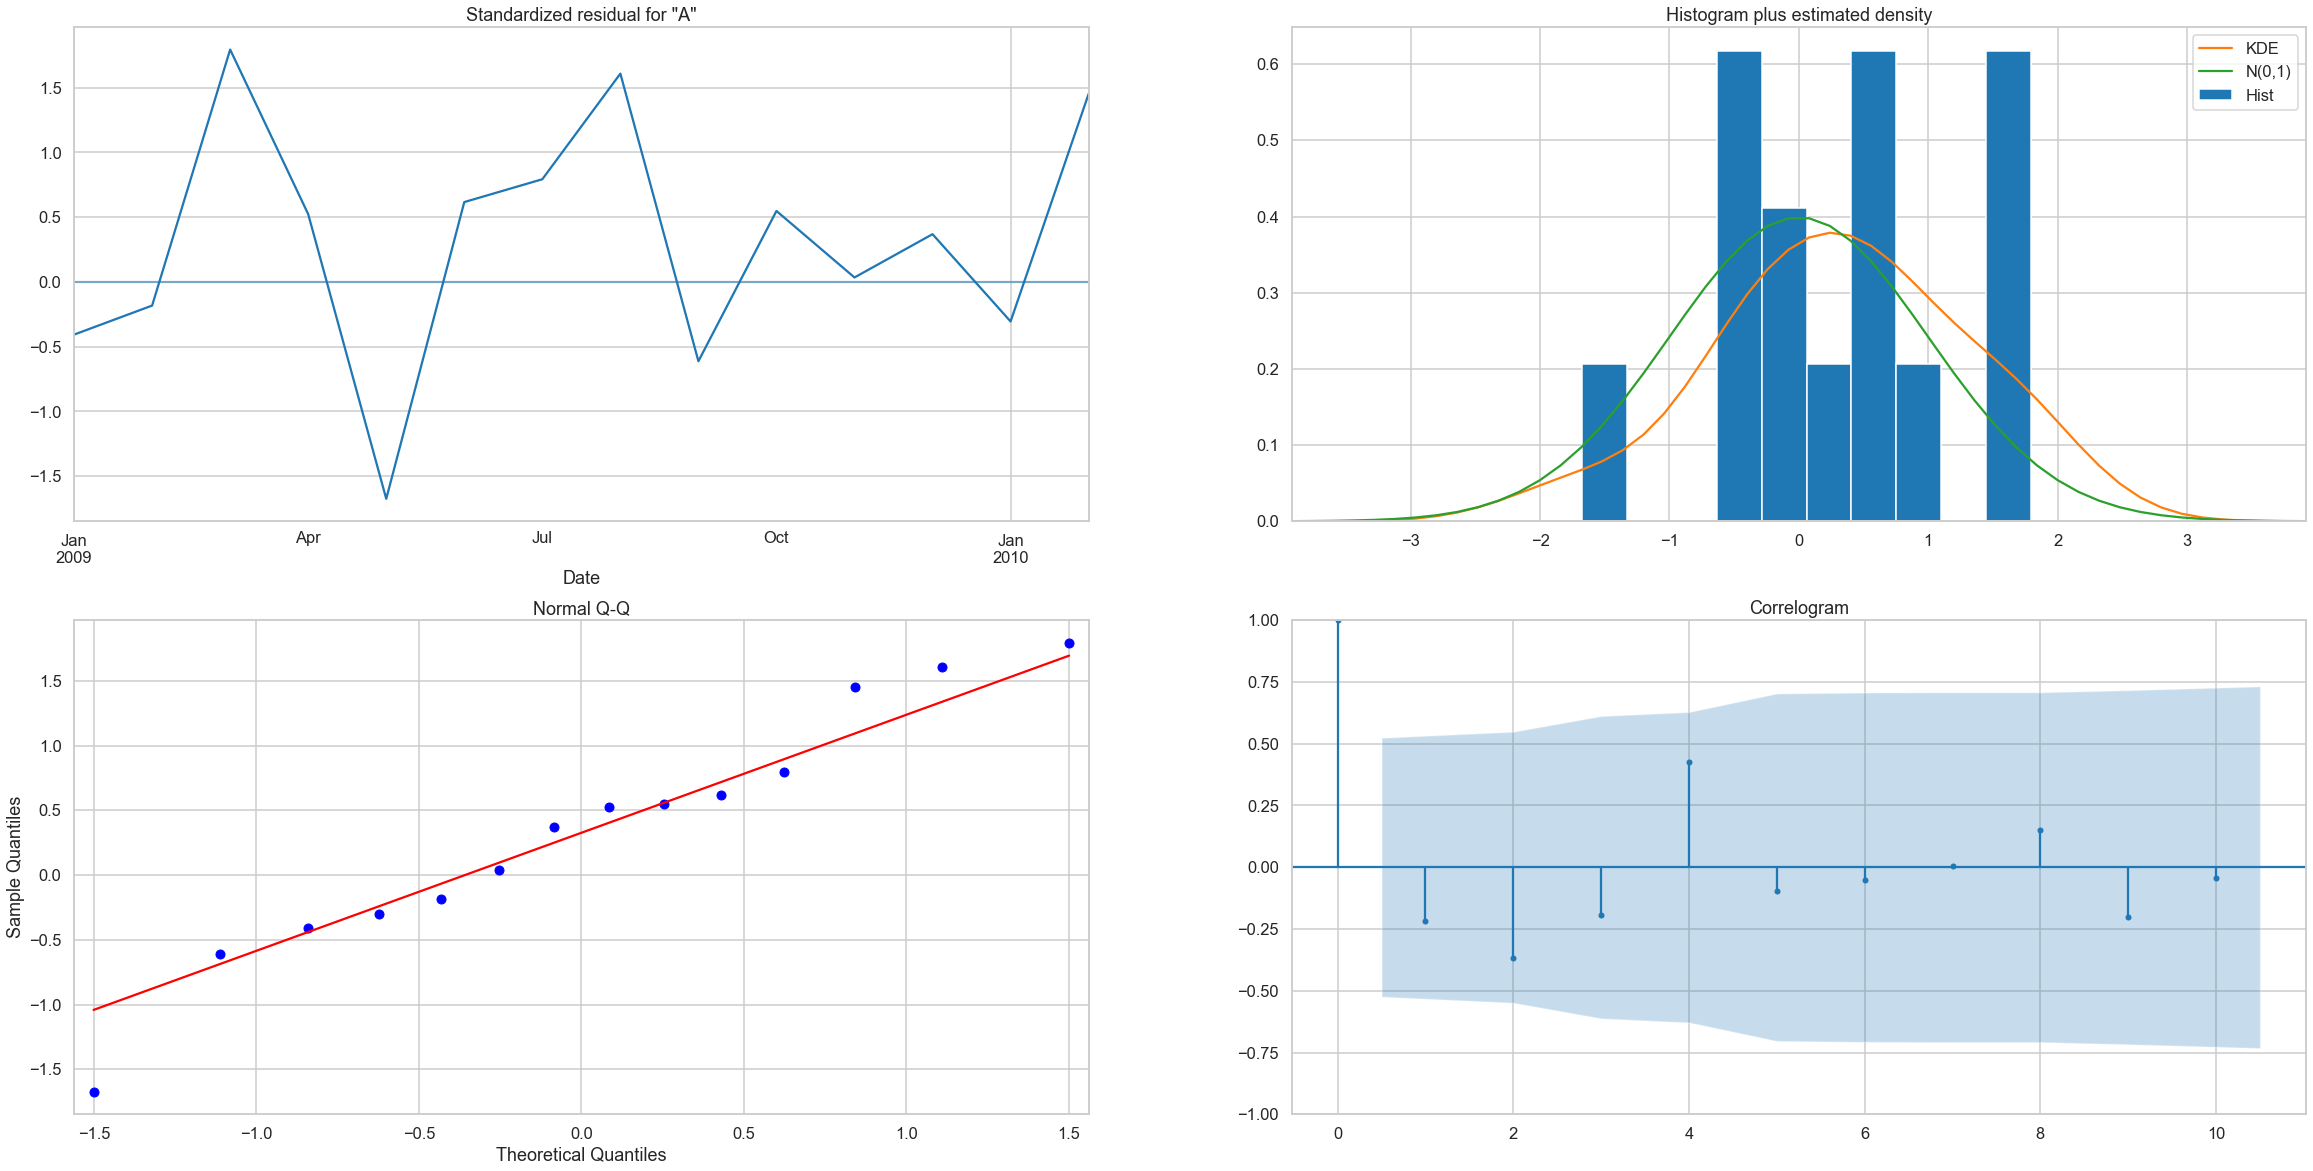

In [31]:
model_aic4.plot_diagnostics(figsize=(40,20))
plt.show()

In [32]:
data1['model4'] = model_aic4.predict(start=25, end=31, dynamic=True)
data1.tail(7)

,Arrival,model1,model2,model3,model4
Date,,,,,
2010-02-01,993.214286,930.178571,944.319381,918.417457,911.841490
2010-03-01,1035.483871,1246.903226,1025.561384,1364.556773,1467.289869
2010-04-01,1151.666667,1084.933333,908.284321,1178.453090,1261.394673
2010-05-01,900.806452,955.645161,1092.835049,875.457038,823.540796
2010-06-01,925.666667,905.900000,897.178468,906.934687,917.135316
2010-07-01,842.583871,958.290323,814.086547,1034.327975,1102.351447
2010-08-01,917.741935,1104.032258,858.178569,1235.895928,1348.169662


<AxesSubplot:xlabel='Date'>

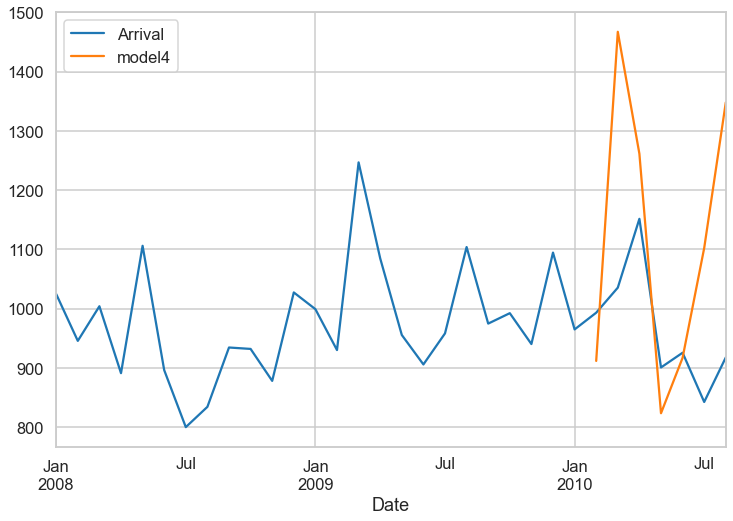

In [33]:
data1[['Arrival','model4']].plot(figsize=(12,8))

### Plotting all the forecasted values vs the actual values for the test data!

Text(0.5, 1.0, 'Comparing model accuracy on test data')

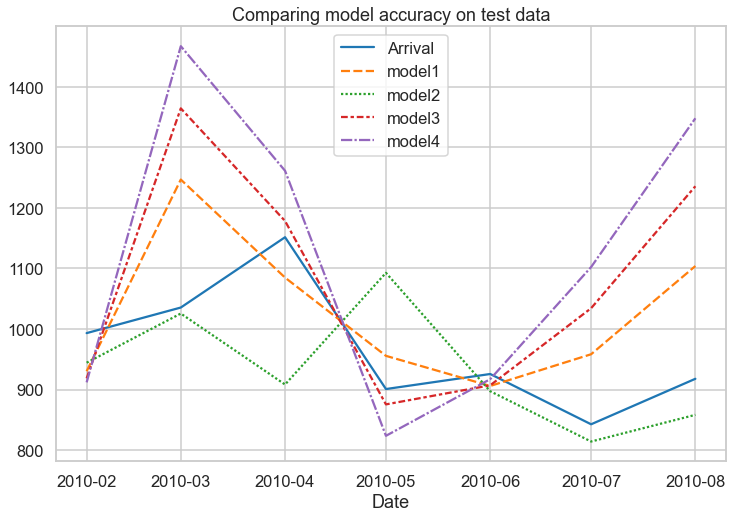

In [34]:
sns.lineplot(data=data1[25:])
plt.title('Comparing model accuracy on test data')

- It is very clear that -> model 1 and model 2 are giving better forecasts forecasts over the test data!

### Let's also check Mean absolute percentage error (MAPE) for the 3 models:

In [35]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true) * 100)

In [36]:
print('MAPE for ARIMA(0,0,0)X(0,1,0)12: {}'.format(mean_absolute_percentage_error(data1[25:]['Arrival'],data1[25:]['model1'])))
print('MAPE for ARIMA(0,0,0)X(1,1,0)12: {}'.format(mean_absolute_percentage_error(data1[25:]['Arrival'],data1[25:]['model2'])))
print('MAPE for ARIMA(0,0,0)X(0,1,1)12: {}'.format(mean_absolute_percentage_error(data1[25:]['Arrival'],data1[25:]['model3'])))
print('MAPE for ARIMA(0,0,1)X(1,1,1)12: {}'.format(mean_absolute_percentage_error(data1[25:]['Arrival'],data1[25:]['model4'])))

MAPE for ARIMA(0,0,0)X(0,1,0)12: 10.687546170549812
MAPE for ARIMA(0,0,0)X(1,1,0)12: 8.754505273372342
MAPE for ARIMA(0,0,0)X(0,1,1)12: 14.84253088519145
MAPE for ARIMA(0,0,1)X(1,1,1)12: 20.95016675428062


- Also the MAPE for the model2 is very low when compared to the other models!

### Forecasting for the future

In [37]:
from pandas.tseries.offsets import DateOffset
future_dates=[data1.index[-1]+ DateOffset(months=x)for x in range(0,15)]

In [38]:
future_data=pd.DataFrame(index=future_dates[1:],columns=data1.columns)

In [39]:
future_data.shape

(14, 5)

In [40]:
future_df=pd.concat([data1,future_data])

In [41]:
future_df.tail()

,Arrival,model1,model2,model3,model4
2011-06-01,NaN,NaN,NaN,NaN,NaN
2011-07-01,NaN,NaN,NaN,NaN,NaN
2011-08-01,NaN,NaN,NaN,NaN,NaN
2011-09-01,NaN,NaN,NaN,NaN,NaN
2011-10-01,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'Forecasting the arrivals of future months')

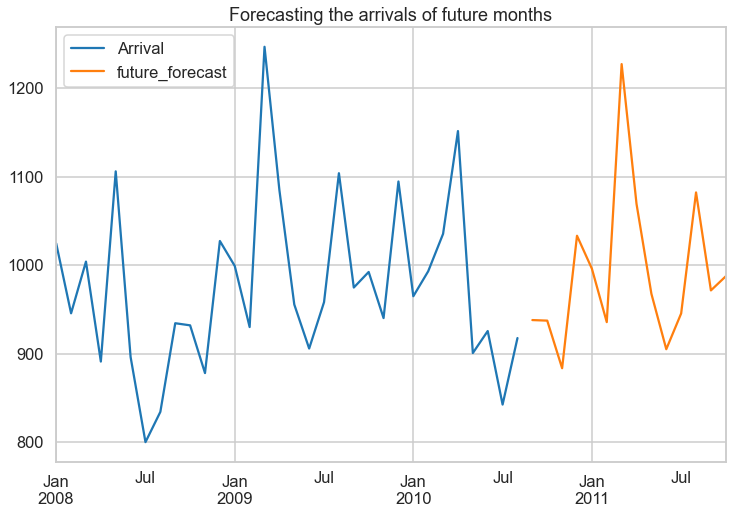

In [42]:
future_df['future_forecast'] = model_aic2.predict(start = 32, end = 45, dynamic= True)  
future_df[['Arrival', 'future_forecast']].plot(figsize=(12, 8))
plt.title('Forecasting the arrivals of future months')